# Casos prácticos

En este notebook vamos a abordar dos casos prácticos interesantes.

1. Predicción (*forecasting*) de la demanda de bicicletas
2. Clasificación multiclase de imágenes

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
from utils import plot_confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,train_test_split
from sklearn.linear_model import Lasso,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, tree
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix,roc_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

# *Hacemos el split Train y Test*


In [3]:
full_df = pd.read_csv('./Proyecto/Proyecto/airbnb-listings-extract.csv',sep=';', decimal='.')
full_df.head(5).T

,0,1,2,3,4
ID,11210388,17471131,17584891,5398030,18104606
Listing Url,https://www.airbnb.com/rooms/11210388,https://www.airbnb.com/rooms/17471131,https://www.airbnb.com/rooms/17584891,https://www.airbnb.com/rooms/5398030,https://www.airbnb.com/rooms/18104606
Scrape ID,20170306202425,20170407214050,20170407214050,20170407214050,20170407214050
Last Scraped,2017-03-07,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,The Loft-Full Bath-Deck w/View,"Claris I, Friendly Rentals","Style Terrace Red, Friendly Rentals",Picasso Suite 1.4 Paseo de Gracia,Smart City Centre Apartment II
Summary,Loft in the Hill country 12-15 minutes directl...,"This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",Live like a local in Barcelona's most chic dis...,"Unique apartment in vibrant neighborhoods, car..."
Space,This loft has a spectacular view of the hills ...,"This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",You wake up to the sun rising over Barcelona's...,"License: HUTB-005313 Charming apartment, locat..."
Description,Loft in the Hill country 12-15 minutes directl...,"This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",Live like a local in Barcelona's most chic dis...,"Unique apartment in vibrant neighborhoods, car..."
Experiences Offered,none,none,none,none,none
Neighborhood Overview,This neighborhood is located in the hills west...,Plaza Cataluña Catalonia Square is the large...,Plaza Cataluña Catalonia Square is the large...,We're right in the heart of the chic L'Eixampl...,NaN


In [4]:
# Vemos que la variable a adivinar no es categórica, si no que es una variable continua
full_df['Price'].nunique()

370

In [5]:
# No estratificamos ya que se trata de un problema de regresión y no de uno de clasificación, por lo que no aporta mucho valor. Si acaso hacerlo por país para tener un train y test representativo,, ya que hay muchos de un país y pocos de otros,  pero no considero que sea necesario
train, test = train_test_split(full_df, test_size=0.25, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./Proyecto/Proyecto/airbnb_train.csv', sep=';', decimal='.', index=False)
test.to_csv('./Proyecto/Proyecto/airbnb_test.csv', sep=';', decimal='.', index=False)


Dimensiones del dataset de training: (11085, 89)
Dimensiones del dataset de test: (3695, 89)


In [6]:
# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
data = pd.read_csv('./Proyecto/Proyecto/airbnb_train.csv',sep=';', decimal='.')

# *Análisis Exploratorio*

In [7]:
data.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

In [8]:
data.shape

(11085, 89)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11085 entries, 0 to 11084
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              11085 non-null  int64  
 1   Listing Url                     11085 non-null  object 
 2   Scrape ID                       11085 non-null  int64  
 3   Last Scraped                    11085 non-null  object 
 4   Name                            11084 non-null  object 
 5   Summary                         10638 non-null  object 
 6   Space                           8179 non-null   object 
 7   Description                     11079 non-null  object 
 8   Experiences Offered             11085 non-null  object 
 9   Neighborhood Overview           6863 non-null   object 
 10  Notes                           4254 non-null   object 
 11  Transit                         6795 non-null   object 
 12  Access                          

# Eliminacion de Variables

In [10]:
# Para poder analizar mejor las variables vamos a eliminar aquellas que de primera mano sabemos que no nos van a hacer falta: IDs, URLs, Columnas con texto libre, Geolocation (ya que tengo la latitud y longitud por separado), similares
columns_to_drop = [
    'Host Name','ID', 'Listing Url', 'Scrape ID', 'Name', 'Summary','Space', 'Description', 'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 
    'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url','Host ID', 'Host URL', 'Host About', 'Host Thumbnail Url','Host Picture Url', 'Host Neighbourhood', 'License', 'Geolocation',
    'Zipcode','Neighbourhood','Smart Location','Country Code','Neighbourhood Group Cleansed','Street'
]

data = data.drop(columns_to_drop, axis=1)


In [11]:
# Eliminamos tambien las variables con muchos nulos y las fechas que me falta info
nulls_to_drop = ['Jurisdiction Names', 'Has Availability', 'Square Feet', 'Host Acceptance Rate', 'First Review', 'Last Review']

data = data.drop(nulls_to_drop, axis=1)

In [12]:
data.shape

(11085, 51)

Vemos que hemos reducido considerablemente el número de variables, aunque todavía tenemos trabajo.

In [13]:
# Vemos que la columna Price tiene nulls, asi que esos valores camos a eliminarlos ya que no podremos comprobar si son correctos 
data = data.dropna(subset=['Price'])
data.shape

(11071, 51)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11071 entries, 0 to 11084
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Last Scraped                    11071 non-null  object 
 1   Experiences Offered             11071 non-null  object 
 2   Host Since                      11069 non-null  object 
 3   Host Location                   11042 non-null  object 
 4   Host Response Time              9650 non-null   object 
 5   Host Response Rate              9650 non-null   float64
 6   Host Listings Count             11069 non-null  float64
 7   Host Total Listings Count       11069 non-null  float64
 8   Host Verifications              11066 non-null  object 
 9   Neighbourhood Cleansed          11071 non-null  object 
 10  City                            11067 non-null  object 
 11  State                           10960 non-null  object 
 12  Market                          11028

In [15]:
data.describe()

,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
count,9650.000000,11069.000000,11069.000000,11071.000000,11071.000000,11071.000000,11030.000000,11051.000000,11037.000000,11071.000000,2692.000000,2686.000000,4756.000000,6551.000000,11071.000000,11071.000000,11071.000000,11071.000000,11071.000000,11071.000000,11071.000000,11071.000000,11071.000000,8579.000000,8559.000000,8564.000000,8553.000000,8563.000000,8551.000000,8549.000000,11067.000000,8694.000000
mean,94.840829,12.860602,12.860602,40.483617,-3.721415,3.284527,1.287443,1.346575,2.049742,74.194111,379.881129,1438.178332,188.786375,32.056175,1.581610,7.571312,3.136121,970.604552,8.950863,22.951766,39.796405,202.018607,22.585855,91.637953,9.412081,9.322630,9.622355,9.646853,9.535961,9.211487,9.685823,1.870591
std,15.127823,34.771038,34.771038,4.717339,13.873989,2.093431,0.663711,0.903418,1.624380,72.357472,194.817635,1207.454067,115.415172,29.875976,1.150704,11.227175,13.828554,9700.396747,9.333272,19.765669,29.663087,128.063616,38.023634,9.064556,0.930488,0.997578,0.804876,0.763731,0.773289,0.957547,23.900659,1.873317
min,0.000000,0.000000,0.000000,-37.851182,-122.437371,1.000000,0.000000,0.000000,1.000000,9.000000,70.000000,250.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000
25%,100.000000,1.000000,1.000000,40.409774,-3.707544,2.000000,1.000000,1.000000,1.000000,34.000000,220.000000,750.000000,100.000000,15.000000,1.000000,0.000000,1.000000,365.000000,0.000000,4.000000,11.000000,78.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.450000
50%,100.000000,2.000000,2.000000,40.419321,-3.700771,3.000000,1.000000,1.000000,2.000000,56.000000,350.000000,1246.000000,150.000000,25.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,20.000000,38.000000,240.000000,7.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.200000
75%,100.000000,6.000000,6.000000,40.430722,-3.684141,4.000000,1.000000,2.000000,2.000000,88.000000,500.000000,1750.000000,200.000000,40.000000,2.000000,15.000000,3.000000,1125.000000,14.000000,38.000000,65.000000,319.000000,27.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.770000
max,100.000000,519.000000,519.000000,55.956716,153.371427,16.000000,8.000000,10.000000,16.000000,969.000000,999.000000,25000.000000,990.000000,500.000000,16.000000,276.000000,1125.000000,1000000.000000,30.000000,60.000000,90.000000,365.000000,344.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,145.000000,17.210000


In [16]:
sorted_df = data.sort_values(by='Last Scraped')
sorted_df['Last Scraped'].head(10)

1732     2016-01-04
4665     2016-01-04
3144     2016-01-04
10910    2016-01-04
959      2016-04-02
5115     2016-04-11
2384     2016-04-11
8011     2016-04-12
9601     2016-04-12
9767     2016-05-04
Name: Last Scraped, dtype: object

In [17]:
sorted_df =data.sort_values(by='Last Scraped', ascending=False)
sorted_df['Last Scraped'].head(10)

9899    2017-06-15
4639    2017-06-15
5780    2017-06-15
2270    2017-06-15
2298    2017-06-15
66      2017-06-15
3688    2017-06-15
373     2017-06-15
209     2017-06-15
3374    2017-06-15
Name: Last Scraped, dtype: object

In [18]:
sorted_df = data.sort_values(by='Calendar last Scraped')
sorted_df['Calendar last Scraped'].head(10)

1732     2016-01-04
4665     2016-01-04
10910    2016-01-04
3144     2016-01-04
959      2016-04-02
5115     2016-04-11
2384     2016-04-11
8011     2016-04-11
9601     2016-04-12
9767     2016-05-04
Name: Calendar last Scraped, dtype: object

In [19]:
sorted_df =data.sort_values(by='Calendar last Scraped', ascending=False)
sorted_df['Calendar last Scraped'].head(10)

209     2017-06-15
373     2017-06-15
66      2017-06-15
2270    2017-06-15
4639    2017-06-15
3374    2017-06-15
9899    2017-06-15
2298    2017-06-15
5780    2017-06-15
3688    2017-06-15
Name: Calendar last Scraped, dtype: object

In [20]:
sorted_df =data.sort_values(by='Host Since')
sorted_df['Host Since'].head(10)

9860     2009-05-17
1076     2009-06-02
10018    2009-06-02
8946     2009-06-02
5345     2009-08-14
6680     2009-08-30
6174     2009-11-12
7949     2009-11-12
1160     2009-11-12
7209     2010-01-14
Name: Host Since, dtype: object

In [21]:
sorted_df =data.sort_values(by='Host Since', ascending=False)
sorted_df['Host Since'].head(10)

9052    2017-04-07
8147    2017-04-07
1461    2017-04-07
6932    2017-04-07
2475    2017-04-07
6509    2017-04-07
7671    2017-04-07
3802    2017-04-07
3382    2017-04-07
3017    2017-04-07
Name: Host Since, dtype: object

In [22]:
# Elimino las fechas que ya no necesito o que no considero relevantes debido a que el intervalo es de solo 1 año
data = data.drop(['Calendar last Scraped','Last Scraped'], axis=1)

# Rellenamos los nulos con diferentes métodos

In [23]:
data.isnull().any()

Experiences Offered               False
Host Since                         True
Host Location                      True
Host Response Time                 True
Host Response Rate                 True
Host Listings Count                True
Host Total Listings Count          True
Host Verifications                 True
Neighbourhood Cleansed            False
City                               True
State                              True
Market                             True
Country                            True
Latitude                          False
Longitude                         False
Property Type                     False
Room Type                         False
Accommodates                      False
Bathrooms                          True
Bedrooms                           True
Beds                               True
Bed Type                          False
Amenities                          True
Price                             False
Weekly Price                       True


In [24]:
# Los rellenamos con 0 porque son precios vacíos
columns_to_fill = ["Weekly Price", "Monthly Price", "Security Deposit", "Cleaning Fee"]
data[columns_to_fill] = data[columns_to_fill].fillna(0)

# Los rellenamos con la media
columns_to_fill_mean = [
    "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness",
    "Review Scores Checkin", "Review Scores Communication", "Review Scores Location",
    "Review Scores Value", "Reviews per Month", "Host Response Rate",
    "Host Listings Count", "Host Total Listings Count", "Beds",
    "Calculated host listings count"
]

data[columns_to_fill_mean] = data[columns_to_fill_mean].apply(lambda x: x.fillna(x.mean()))

# Relleno con la mediana para los 2 casos que me quedan de esta columna
data['Host Since'] = data['Host Since'].fillna(data['Host Since'].mode()[0])

In [25]:
data.isnull().any()

Experiences Offered               False
Host Since                        False
Host Location                      True
Host Response Time                 True
Host Response Rate                False
Host Listings Count               False
Host Total Listings Count         False
Host Verifications                 True
Neighbourhood Cleansed            False
City                               True
State                              True
Market                             True
Country                            True
Latitude                          False
Longitude                         False
Property Type                     False
Room Type                         False
Accommodates                      False
Bathrooms                          True
Bedrooms                           True
Beds                              False
Bed Type                          False
Amenities                          True
Price                             False
Weekly Price                      False


Ya tengo todos los datos rellenos por lo que puedo hacer más análisis

# *Eliminación de Outliers*

In [26]:
data.loc[data['Bathrooms']>7,['Bedrooms','Bathrooms']]

,Bedrooms,Bathrooms
3073,1.0,8.0
3403,1.0,8.0
5036,6.0,7.5
8683,1.0,8.0


In [27]:
# Vemos que hay un par de casos que parecen erróneos, aquellos que tienen 8 baños y 1 habitacion, por lo que los excluimos
data = data[data['Bathrooms']<8]

In [28]:
data.loc[data['Bedrooms']>7,['Bedrooms','Bathrooms', 'Beds']]

,Bedrooms,Bathrooms,Beds
469,10.0,7.0,16.0
801,10.0,6.0,16.0
1872,8.0,3.0,13.0
3611,10.0,5.5,1.0
5035,8.0,3.0,12.0
6079,10.0,6.0,16.0
6789,10.0,0.0,2.0
6986,10.0,3.0,16.0
9547,8.0,4.5,16.0
9736,8.0,4.0,13.0


In [29]:
# Lo mismo ocurre con las camas y habitaciones, descartamos aquellos con menos camas que habitaciones a partir de 7 habitaciones y menos de 7 camas
data = data[data['Bedrooms']<8]

# *Codificacion de Variables*

In [30]:
data.head(5).T

,0,1,2,3,4
Experiences Offered,none,none,none,none,none
Host Since,2012-11-20,2015-12-16,2014-09-19,2012-01-23,2015-06-13
Host Location,"Palma de Mallorca, Balearic Islands, Spain","Madrid, Community of Madrid, Spain","Madrid, Community of Madrid, Spain","Vienna, Wien, Austria","Barcelona, Catalonia, Spain"
Host Response Time,within an hour,within a day,within a few hours,within an hour,within an hour
Host Response Rate,97.0,90.0,75.0,98.0,100.0
Host Listings Count,68.0,3.0,164.0,21.0,22.0
Host Total Listings Count,68.0,3.0,164.0,21.0,22.0
Host Verifications,"email,phone,facebook,reviews,jumio","email,phone,reviews","email,phone,reviews","email,phone,jumio","email,phone,google,reviews,jumio,work_email"
Neighbourhood Cleansed,Sóller,Acacias,Embajadores,Landstra§e,Sol
City,Sóller,Madrid,Madrid,Wien,Madrid


In [31]:
from sklearn.preprocessing import LabelEncoder

le_features = LabelEncoder()
data["Features"] = le_features.fit_transform(data["Features"])

le_cancellation_policy = LabelEncoder()
data["Cancellation Policy"] = le_cancellation_policy.fit_transform(data["Cancellation Policy"])

le_calendar_updated = LabelEncoder()
data["Calendar Updated"] = le_calendar_updated.fit_transform(data["Calendar Updated"])

le_amenities = LabelEncoder()
data["Amenities"] = le_amenities.fit_transform(data["Amenities"])

le_bed_type = LabelEncoder()
data["Bed Type"] = le_bed_type.fit_transform(data["Bed Type"])

le_room_type = LabelEncoder()
data["Room Type"] = le_room_type.fit_transform(data["Room Type"])

le_property_type = LabelEncoder()
data["Property Type"] = le_property_type.fit_transform(data["Property Type"])

le_country = LabelEncoder()
data["Country"] = le_country.fit_transform(data["Country"])

le_city = LabelEncoder()
data["City"] = le_city.fit_transform(data["City"])

le_state = LabelEncoder()
data["State"] = le_state.fit_transform(data["State"])

le_market = LabelEncoder()
data["Market"] = le_market.fit_transform(data["Market"])

le_neighbourhood_cleansed = LabelEncoder()
data["Neighbourhood Cleansed"] = le_neighbourhood_cleansed.fit_transform(data["Neighbourhood Cleansed"])

le_host_verifications = LabelEncoder()
data["Host Verifications"] = le_host_verifications.fit_transform(data["Host Verifications"])

le_experiences_offered = LabelEncoder()
data["Experiences Offered"] = le_experiences_offered.fit_transform(data["Experiences Offered"])

le_host_response_time = LabelEncoder()
data["Host Response Time"] = le_host_response_time.fit_transform(data["Host Response Time"])

le_host_location = LabelEncoder()
data["Host Location"] = le_host_location.fit_transform(data["Host Location"])

In [32]:
# Transformo la fecha del host en años y meses para trabajar mejor y elimino la variable original

data['Host Since'] = data['Host Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
data['Host Year'] = data['Host Since'].apply(lambda x: x.year - 2009) #Año del primer valor
data['Host Month'] = data['Host Since'].apply(lambda x: x.month)
data = data.drop(['Host Since'], axis=1)

# *Correlacion*

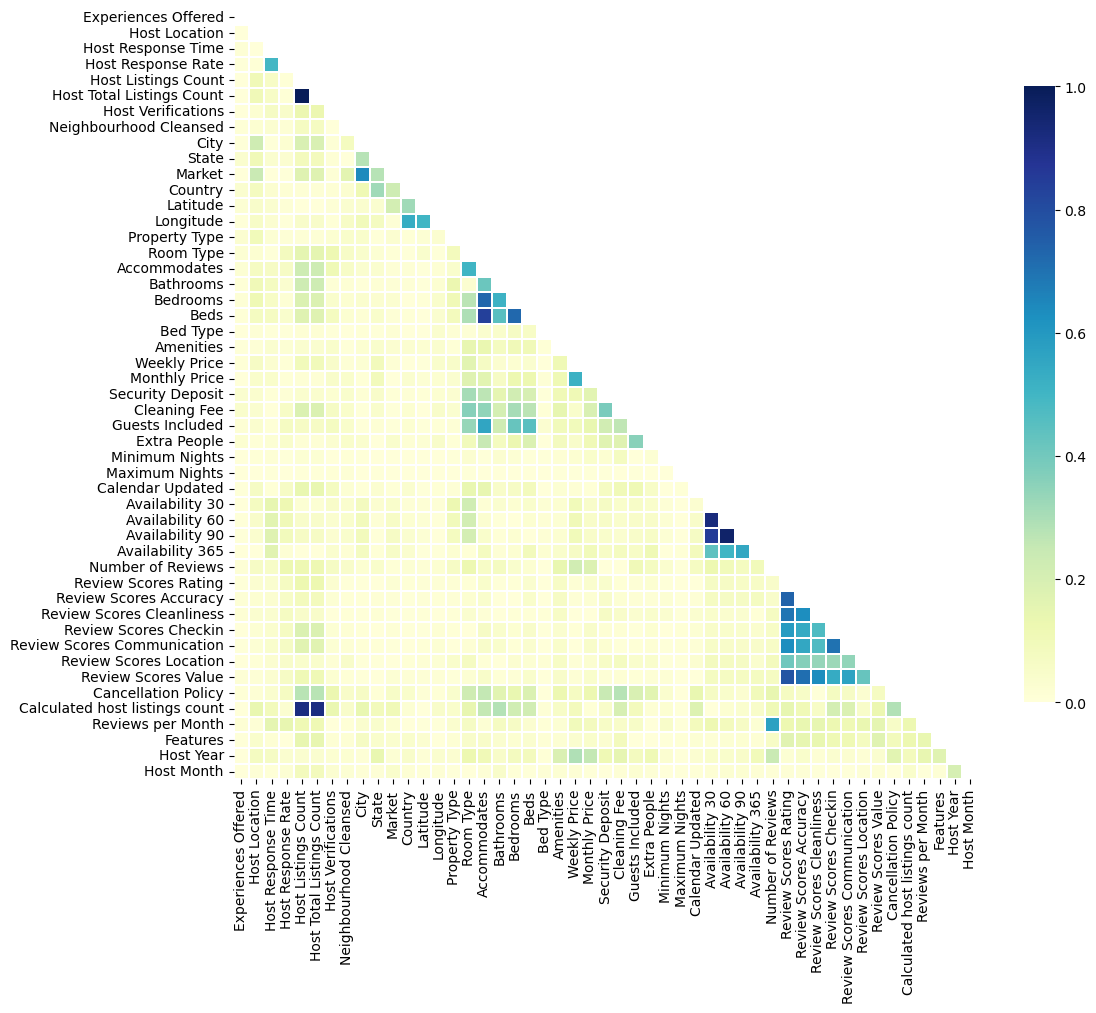

In [33]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Con esta matriz de correlacion ya vemos que hay muchas columnas que son bastante similares, así que vamos a proceder a eliminar las que se parezcan y quedarnos solo con una de cada grupo en el que hay mucha correlacion

In [34]:
corr_to_remove = [
    'Accommodates', 'Monthly Price', 'Reviews per Month',  
    'Availability 60', 'Availability 90', 'Availability 365', 
    'Review Scores Cleanliness', 'Review Scores Accuracy', 
    'Review Scores Communication', 'Review Scores Location', 
    'Review Scores Checkin', 'Review Scores Value', 'Country',
    'Host Total Listings Count', 'Calculated host listings count', 'Beds'
]

data = data.drop(corr_to_remove, axis=1)


# Calculo la relación entre variables


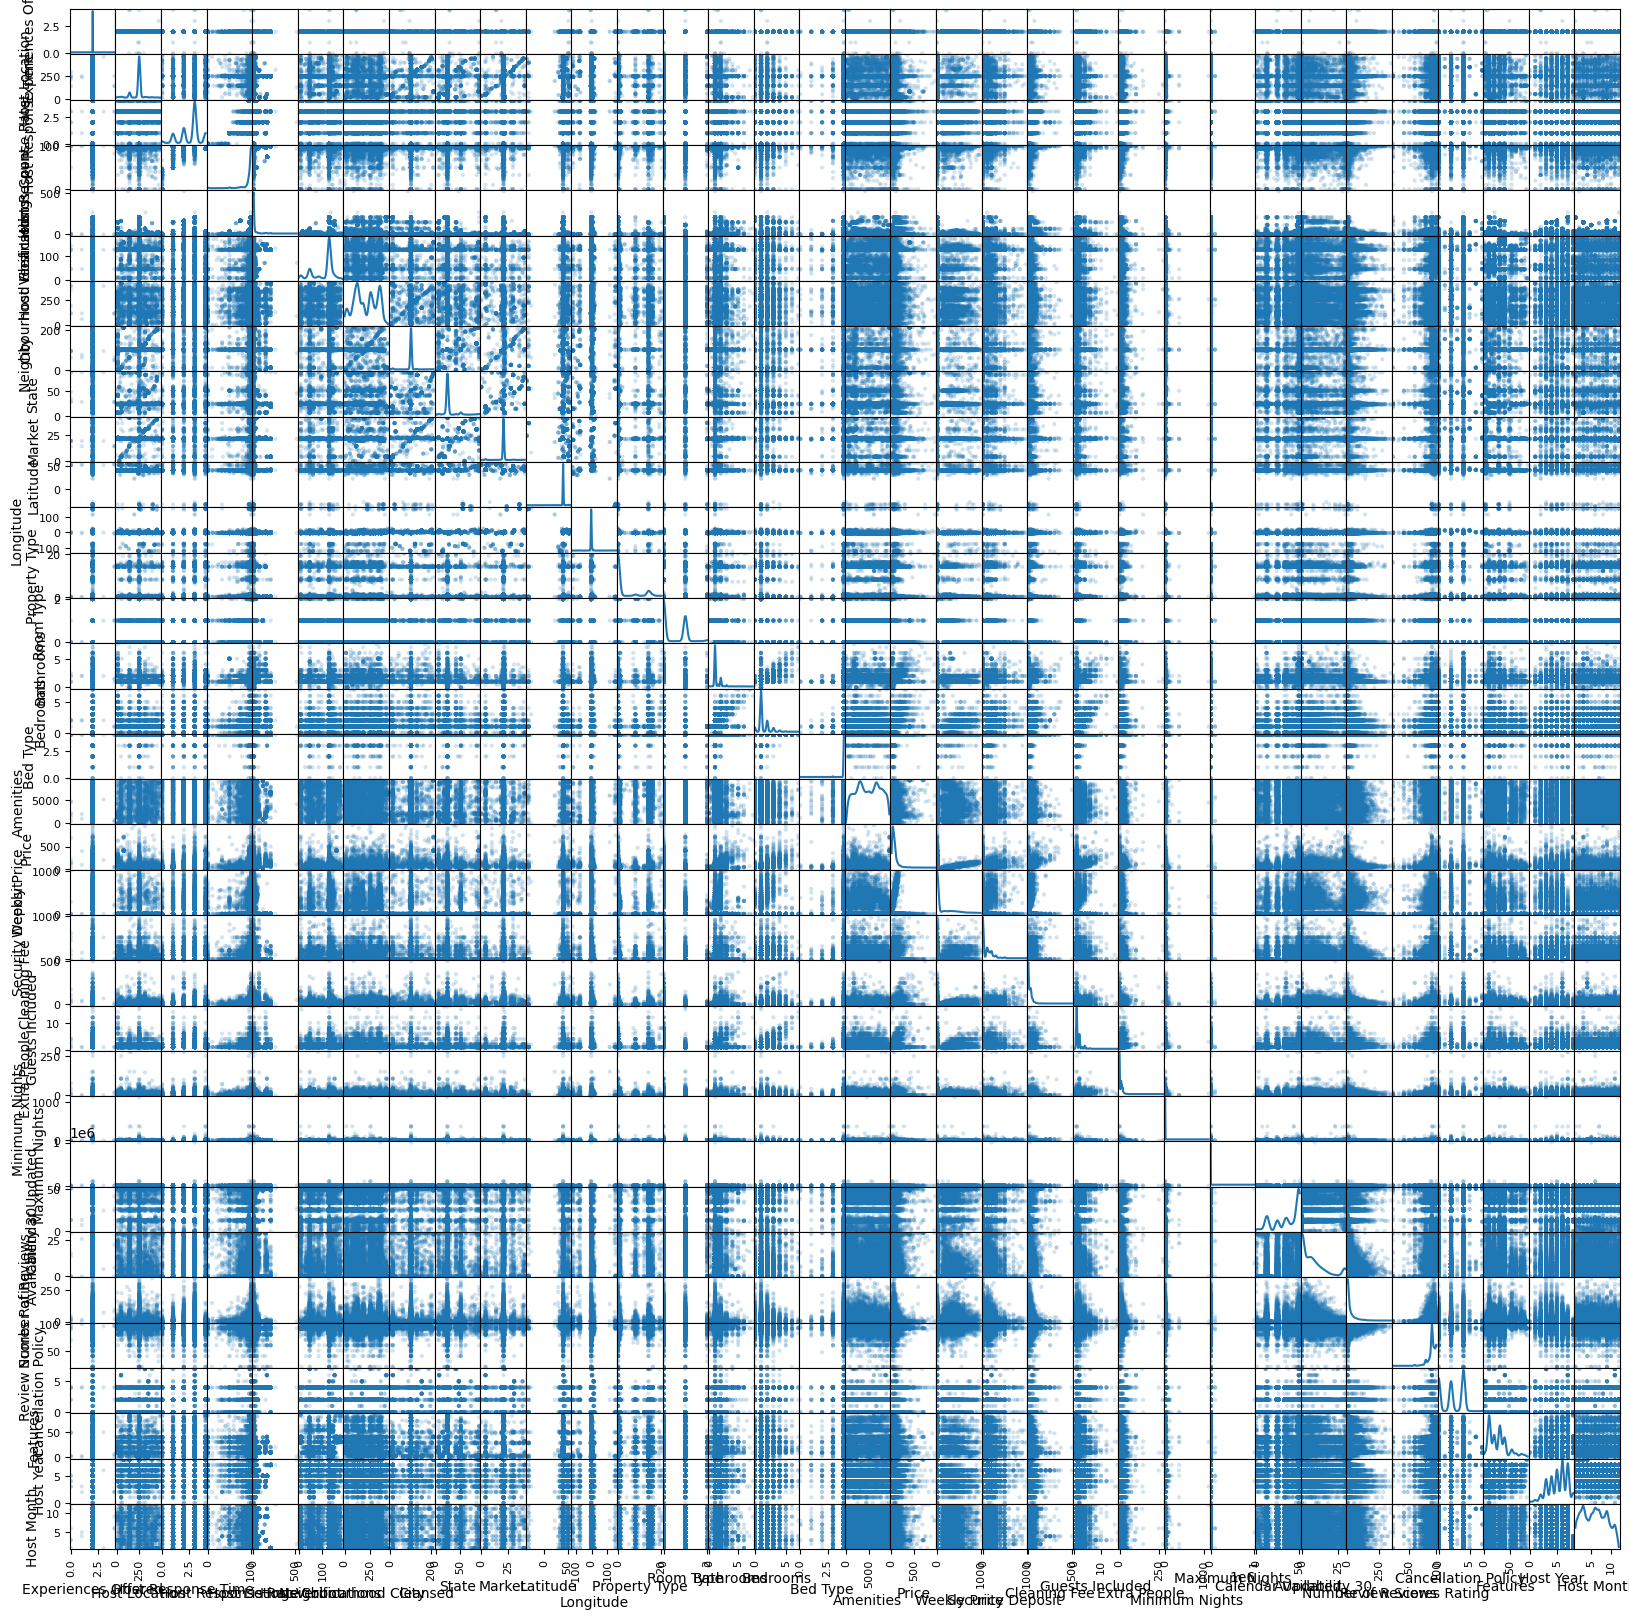

In [35]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

No podemos sacar grandes conclusiones debido al volumen de variables

## Generacion de variables

Generamos un par de variables adicionales, además de las ya creadas con respecto a la fecha del Host.

In [36]:
data['Bedrooms_squared'] = data['Bedrooms'].apply(lambda x: x**2)
data['Bed_bath_rooms']   = data['Bedrooms']*data['Bathrooms']

# Cross Validation, Optimización de Variables y Modelado 

En este punto vamos a agrupar todas las transformaciones realizadas en test para aplicarselas tanto a train como a test, separar la variables a deducir ("Price") y probar varios modelos que nos determinen cuales tienen mejor accuracy

In [37]:
data = pd.read_csv('./Proyecto/Proyecto/airbnb_train.csv',sep=';', decimal='.')

data = data.dropna(subset=['Price'])

columns_to_drop = [
    'Host Name','ID', 'Listing Url', 'Scrape ID', 'Name', 'Summary','Space', 'Description', 'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 
    'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url','Host ID', 'Host URL', 'Host About', 'Host Thumbnail Url','Host Picture Url', 'Host Neighbourhood', 'License', 'Geolocation',
    'Zipcode','Neighbourhood','Smart Location','Country Code','Neighbourhood Group Cleansed','Street'
]
data = data.drop(columns_to_drop, axis=1)

nulls_to_drop = ['Jurisdiction Names', 'Has Availability', 'Square Feet', 'Host Acceptance Rate', 'First Review', 'Last Review']
data = data.drop(nulls_to_drop, axis=1)

data = data.drop(['Calendar last Scraped','Last Scraped'], axis=1)

columns_to_fill = ["Weekly Price", "Monthly Price", "Security Deposit", "Cleaning Fee"]
data[columns_to_fill] = data[columns_to_fill].fillna(0)
columns_to_fill_mean = [
    "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness",
    "Review Scores Checkin", "Review Scores Communication", "Review Scores Location",
    "Review Scores Value", "Reviews per Month", "Host Response Rate",
    "Host Listings Count", "Host Total Listings Count", "Beds",
    "Calculated host listings count"
]
data[columns_to_fill_mean] = data[columns_to_fill_mean].apply(lambda x: x.fillna(x.mean()))
data['Host Since'] = data['Host Since'].fillna(data['Host Since'].mode()[0])
data['Host Since'] = data['Host Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
data['Host Year'] = data['Host Since'].apply(lambda x: x.year - 2009) #Año del primer valor
data['Host Month'] = data['Host Since'].apply(lambda x: x.month)
data = data.drop(['Host Since'], axis=1)

data = data[data['Bathrooms']<8]
data = data[data['Bedrooms']<8]

from sklearn.preprocessing import LabelEncoder

le_features = LabelEncoder()
data["Features"] = le_features.fit_transform(data["Features"])

le_cancellation_policy = LabelEncoder()
data["Cancellation Policy"] = le_cancellation_policy.fit_transform(data["Cancellation Policy"])

le_calendar_updated = LabelEncoder()
data["Calendar Updated"] = le_calendar_updated.fit_transform(data["Calendar Updated"])

le_amenities = LabelEncoder()
data["Amenities"] = le_amenities.fit_transform(data["Amenities"])

le_bed_type = LabelEncoder()
data["Bed Type"] = le_bed_type.fit_transform(data["Bed Type"])

le_room_type = LabelEncoder()
data["Room Type"] = le_room_type.fit_transform(data["Room Type"])

le_property_type = LabelEncoder()
data["Property Type"] = le_property_type.fit_transform(data["Property Type"])

le_country = LabelEncoder()
data["Country"] = le_country.fit_transform(data["Country"])

le_city = LabelEncoder()
data["City"] = le_city.fit_transform(data["City"])

le_state = LabelEncoder()
data["State"] = le_state.fit_transform(data["State"])

le_market = LabelEncoder()
data["Market"] = le_market.fit_transform(data["Market"])

le_neighbourhood_cleansed = LabelEncoder()
data["Neighbourhood Cleansed"] = le_neighbourhood_cleansed.fit_transform(data["Neighbourhood Cleansed"])

le_host_verifications = LabelEncoder()
data["Host Verifications"] = le_host_verifications.fit_transform(data["Host Verifications"])

le_experiences_offered = LabelEncoder()
data["Experiences Offered"] = le_experiences_offered.fit_transform(data["Experiences Offered"])

le_host_response_time = LabelEncoder()
data["Host Response Time"] = le_host_response_time.fit_transform(data["Host Response Time"])

le_host_location = LabelEncoder()
data["Host Location"] = le_host_location.fit_transform(data["Host Location"])

corr_to_remove = [
    'Accommodates', 'Monthly Price', 'Reviews per Month',  
    'Availability 60', 'Availability 90', 'Availability 365', 
    'Review Scores Cleanliness', 'Review Scores Accuracy', 
    'Review Scores Communication', 'Review Scores Location', 
    'Review Scores Checkin', 'Review Scores Value', 'Country',
    'Host Total Listings Count', 'Calculated host listings count', 'Beds'
]
data = data.drop(corr_to_remove, axis=1)

data['Bedrooms_squared'] = data['Bedrooms'].apply(lambda x: x**2)
data['Bed_bath_rooms']   = data['Bedrooms']*data['Bathrooms']


In [38]:
# Cargar los datos de test y le aplicamos las mismas transformaciones
data_test = pd.read_csv('./Proyecto/Proyecto/airbnb_test.csv', sep=';', decimal='.')

data_test = data_test.dropna(subset=['Price'])

columns_to_drop = [
    'Host Name', 'ID', 'Listing Url', 'Scrape ID', 'Name', 'Summary', 'Space', 'Description', 
    'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 
    'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 
    'Host About', 'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'License', 
    'Geolocation', 'Zipcode', 'Neighbourhood', 'Smart Location', 'Country Code', 
    'Neighbourhood Group Cleansed', 'Street'
]
data_test = data_test.drop(columns_to_drop, axis=1)

nulls_to_drop = ['Jurisdiction Names', 'Has Availability', 'Square Feet', 'Host Acceptance Rate', 
                 'First Review', 'Last Review']
data_test = data_test.drop(nulls_to_drop, axis=1)

data_test = data_test.drop(['Calendar last Scraped', 'Last Scraped'], axis=1)

columns_to_fill = ["Weekly Price", "Monthly Price", "Security Deposit", "Cleaning Fee"]
data_test[columns_to_fill] = data_test[columns_to_fill].fillna(0)

columns_to_fill_mean = [
    "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness",
    "Review Scores Checkin", "Review Scores Communication", "Review Scores Location",
    "Review Scores Value", "Reviews per Month", "Host Response Rate", 
    "Host Listings Count", "Host Total Listings Count", "Beds",
    "Calculated host listings count"
]
data_test[columns_to_fill_mean] = data_test[columns_to_fill_mean].apply(lambda x: x.fillna(x.mean()))

data_test['Host Since'] = data_test['Host Since'].fillna(data_test['Host Since'].mode()[0])
data_test['Host Since'] = data_test['Host Since'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_test['Host Year'] = data_test['Host Since'].apply(lambda x: x.year - 2009) 
data_test['Host Month'] = data_test['Host Since'].apply(lambda x: x.month)
data_test = data_test.drop(['Host Since'], axis=1)

data_test = data_test[data_test['Bathrooms'] < 8]
data_test = data_test[data_test['Bedrooms'] < 8]

from sklearn.preprocessing import LabelEncoder

encoders = {
    "Features": LabelEncoder(),
    "Cancellation Policy": LabelEncoder(),
    "Calendar Updated": LabelEncoder(),
    "Amenities": LabelEncoder(),
    "Bed Type": LabelEncoder(),
    "Room Type": LabelEncoder(),
    "Property Type": LabelEncoder(),
    "Country": LabelEncoder(),
    "City": LabelEncoder(),
    "State": LabelEncoder(),
    "Market": LabelEncoder(),
    "Neighbourhood Cleansed": LabelEncoder(),
    "Host Verifications": LabelEncoder(),
    "Experiences Offered": LabelEncoder(),
    "Host Response Time": LabelEncoder(),
    "Host Location": LabelEncoder(),
}

for column, le in encoders.items():
    data_test[column] = le.fit_transform(data_test[column])

corr_to_remove = [
    'Accommodates', 'Monthly Price', 'Reviews per Month',  
    'Availability 60', 'Availability 90', 'Availability 365', 
    'Review Scores Cleanliness', 'Review Scores Accuracy', 
    'Review Scores Communication', 'Review Scores Location', 
    'Review Scores Checkin', 'Review Scores Value', 'Country',
    'Host Total Listings Count', 'Calculated host listings count', 'Beds'
]
data_test = data_test.drop(corr_to_remove, axis=1)

data_test['Bedrooms_squared'] = data_test['Bedrooms'].apply(lambda x: x**2)
data_test['Bed_bath_rooms'] = data_test['Bedrooms'] * data_test['Bathrooms']



In [39]:
from sklearn.preprocessing import StandardScaler

features = data.drop(['Price'], axis=1).columns

X_train = data[features].values
y_train = data['Price'].values

X_test = data_test[features].values
y_test = data_test['Price'].values

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Media de precio en train:%0.3f'%np.mean(y_train))
print('Media de precio en test: %0.3f'%np.mean(y_test))

Datos train:  (10997, 35)
Datos test:   (3667, 35)
Media de precio en train:73.967
Media de precio en test: 70.918


# **Lasso**

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................alpha=0.16768329368110083; total time=   0.0s
[CV] END ..........................alpha=0.167

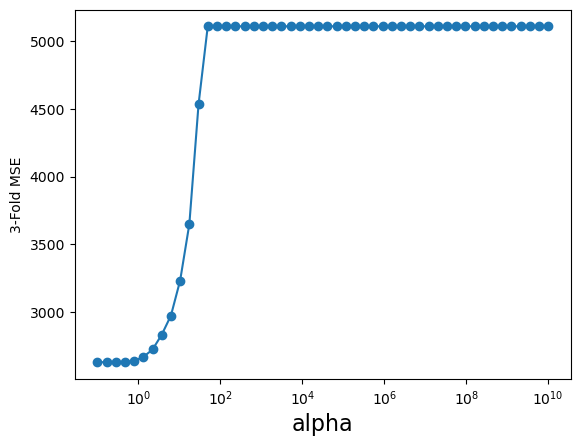

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1,10,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10, verbose=2)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('3-Fold MSE')
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(Xs_train,y_train)

print("Train: ",lasso.score(Xs_train,y_train))
print("Test: ",lasso.score(Xs_test,y_test))

ytrainLasso = lasso.predict(Xs_train)
ytestLasso  = lasso.predict(Xs_test)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = data.columns[1:] # es igual en train y en test

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

Train:  0.49544097797914166
Test:  0.4315544519787454
MSE Modelo Lasso (train): 2.58e+03
MSE Modelo Lasso (test) : 2.66e+03
RMSE Modelo Lasso (train): 50.8
RMSE Modelo Lasso (test) : 51.6
Host Location -1.2751628153629053
Host Response Time -4.475993859259677
Host Response Rate 3.4803316365419317
Host Listings Count -1.899338966018726
Host Verifications 5.347861051976774
Neighbourhood Cleansed 0.7680506780224073
City 0.784104159093445
State 9.453757652036508
Market 13.293954870185441
Latitude -11.254419842821395
Longitude -4.877055744647013
Property Type -2.7925899804811842
Room Type 0.45704676035577113
Bathrooms -17.264706405764393
Bedrooms -0.5948524762673191
Bed Type 1.2505829797711951
Amenities -0.0
Price 0.0
Weekly Price -0.6584666380942081
Security Deposit -0.0
Cleaning Fee 16.21742639817289
Guests Included 0.4477216585203494
Extra People -0.07233724547015494
Minimum Nights -0.12647851407965485
Maximum Nights -0.0
Calendar Updated -0.0
Availability 30 9.343130197199127
Number of 

# **Decision Tree**

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END .......................................

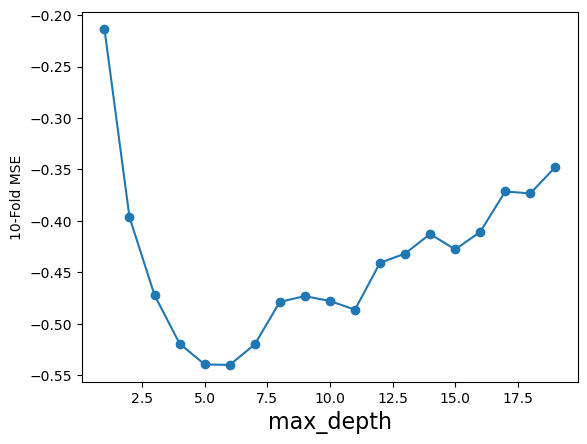

In [42]:
from sklearn.tree import DecisionTreeRegressor

maxDepth = range(1,20)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 5, verbose=2)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(-grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

In [43]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(Xs_train,y_train)

print("Train: ",treeModel.score(Xs_train,y_train))
print("Test: ",treeModel.score(Xs_test,y_test))

ytrainTree = treeModel.predict(Xs_train)
ytestTree  = treeModel.predict(Xs_test)
mseTrainModelTree = mean_squared_error(y_train,ytrainTree)
mseTestModelTree = mean_squared_error(y_test,ytestTree)

print('MSE Modelo Decision Tree (train): %0.3g' % mseTrainModelTree)
print('MSE Modelo Decision Tree (test) : %0.3g' % mseTestModelTree)

Train:  0.7080125146842599
Test:  0.16276349030249093
MSE Modelo Decision Tree (train): 1.49e+03
MSE Modelo Decision Tree (test) : 3.92e+03


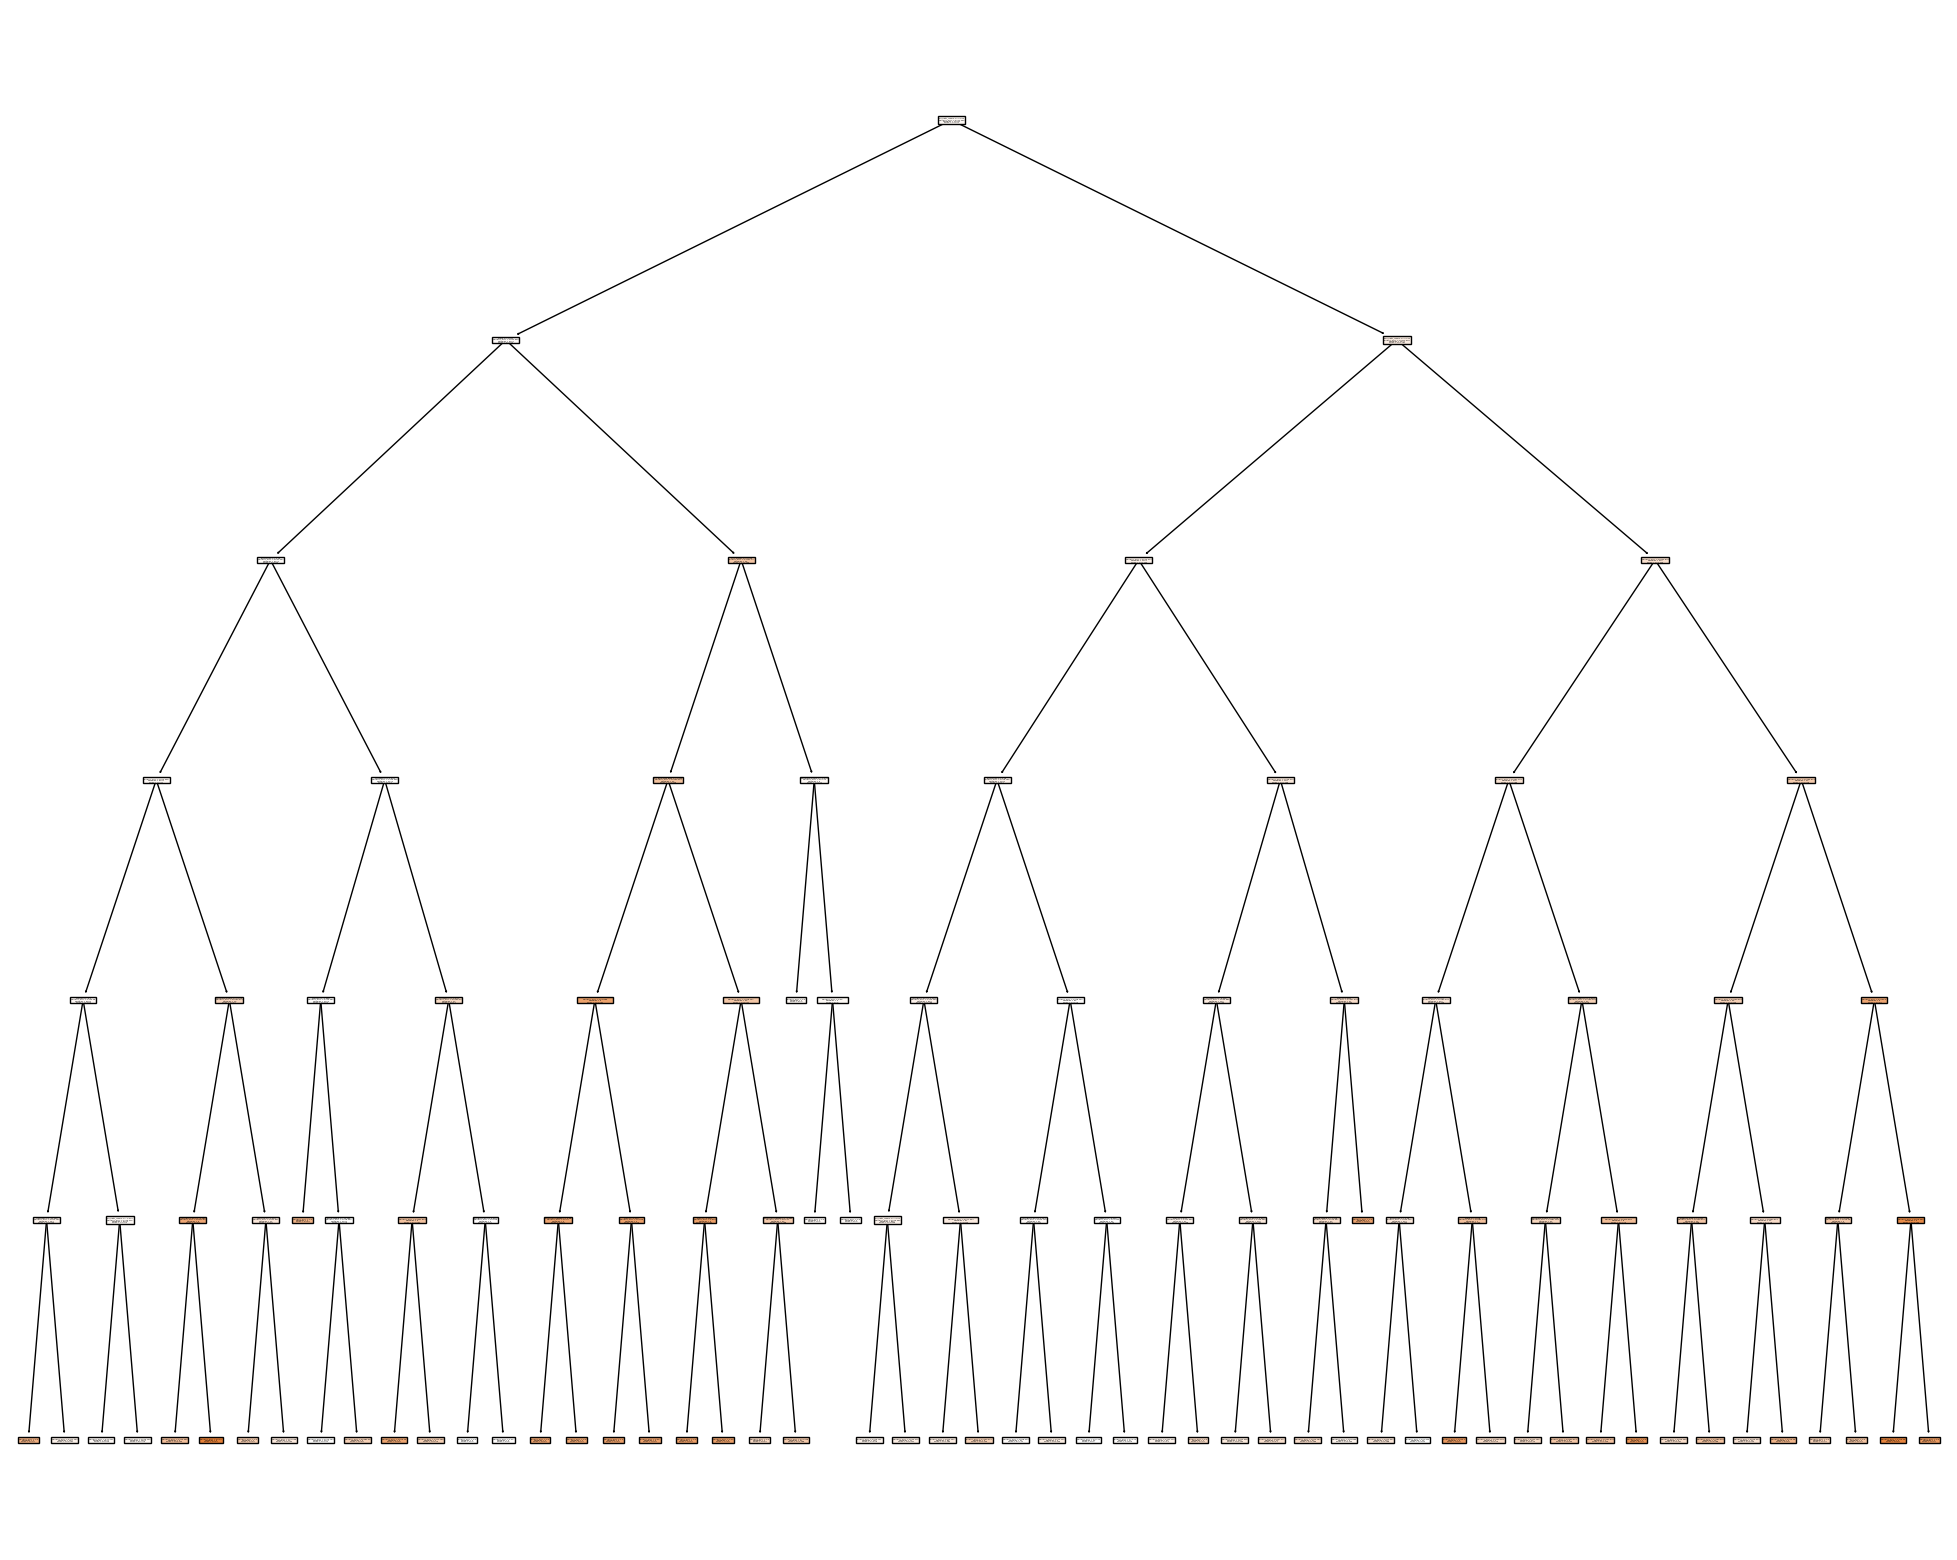

In [44]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(treeModel, feature_names=feature_names, filled=True)

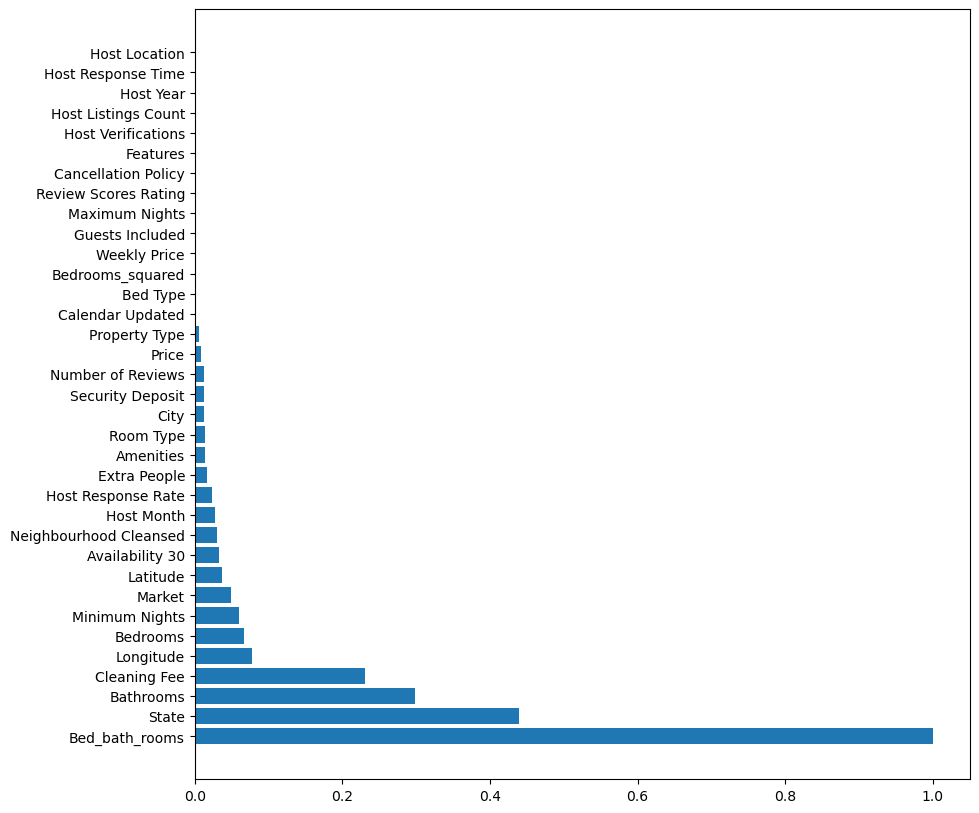

In [45]:
importances = treeModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(Xs_train.shape[1]),importances[indices])
plt.yticks(range(Xs_train.shape[1]),feature_names[indices])
plt.show()

# **Random Forest**

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END ........................................max_depth=1; total time=   0.6s
[CV] END ........................................max_depth=1; total time=   0.4s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.6s
[CV] END ........................................max_depth=3; total time=   0.7s
[CV] END ........................................max_depth=3; total time=   0.7s
[CV] END ........................................max_depth=3; total time=   0.7s
[CV] END ........................................max_depth=4; total time=   0.7s
[CV] END ........................................max_depth=4; total time=   0.9s
[CV] END .......................................

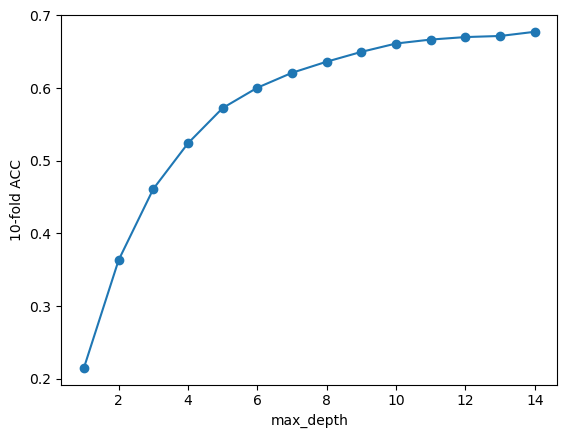

In [46]:
from sklearn.ensemble import RandomForestRegressor

maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=3, verbose=2) 
grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [47]:
maxDepthOptimo = grid.best_params_['max_depth']
randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(Xs_train,y_train)

print("Train: ",randomForest.score(Xs_train,y_train))
print("Test: ",randomForest.score(Xs_test,y_test))

ytrainRF = randomForest.predict(Xs_train)
ytestRF  = randomForest.predict(Xs_test)
mseTrainModelRF = mean_squared_error(y_train,ytrainRF)
mseTestModelRF = mean_squared_error(y_test,ytestRF)

print('MSE Modelo Decision Tree (train): %0.3g' % mseTrainModelRF)
print('MSE Modelo Decision Tree (test) : %0.3g' % mseTestModelRF)

Train:  0.8963175357348758
Test:  0.44293887023211487
MSE Modelo Decision Tree (train): 530
MSE Modelo Decision Tree (test) : 2.61e+03


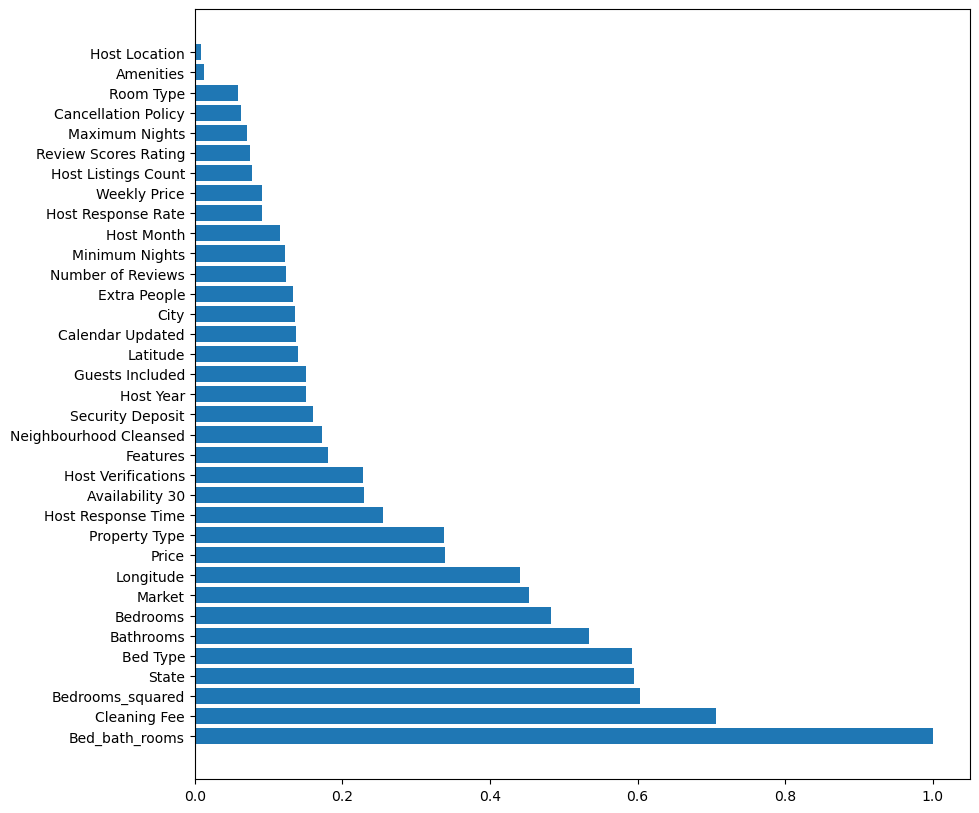

In [48]:
importances = randomForest.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(Xs_train.shape[1]),importances[indices])
plt.yticks(range(Xs_train.shape[1]),feature_names[indices])
plt.show()

# **Gradient Boost**

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,1000,1500,2000]
learningRate = [0.1,0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 3, verbose=2)
grid.fit(Xs_train, y_train)


print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  11.6s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  11.9s
[CV] END ................learning_rate=0.1, n_estimators=500; total time=  11.8s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  23.8s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  23.6s
[CV] END ...............learning_rate=0.1, n_estimators=1000; total time=  23.8s
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=  34.7s
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=  35.1s
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time=  35.1s
[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=  46.9s
[CV] END ...............learning_rate=0.1, n_estimators=2000; total time=  46.5s
[CV] END ...............learning_rate=0.1, n_esti

Train:  0.9428778535005465
Test:  0.4123344429488701
MSE Modelo Boosting Tree (train): 292
MSE Modelo Boosting Tree (test) : 2.61e+03


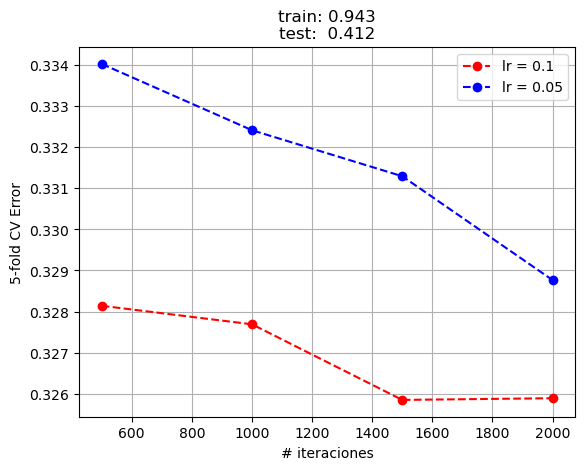

In [50]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(Xs_train,y_train)
print("Train: ",bt.score(Xs_train,y_train))
print("Test: ",bt.score(Xs_test,y_test))

ytrainBF = bt.predict(Xs_train)
ytestBF  = bt.predict(Xs_test)
mseTrainModelRF = mean_squared_error(y_train,ytrainBF)
mseTestModelRF = mean_squared_error(y_test,ytestRF)

print('MSE Modelo Boosting Tree (train): %0.3g' % mseTrainModelRF)
print('MSE Modelo Boosting Tree (test) : %0.3g' % mseTestModelRF)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(Xs_train,y_train),bt.score(Xs_test,y_test)))
plt.grid()
plt.show()

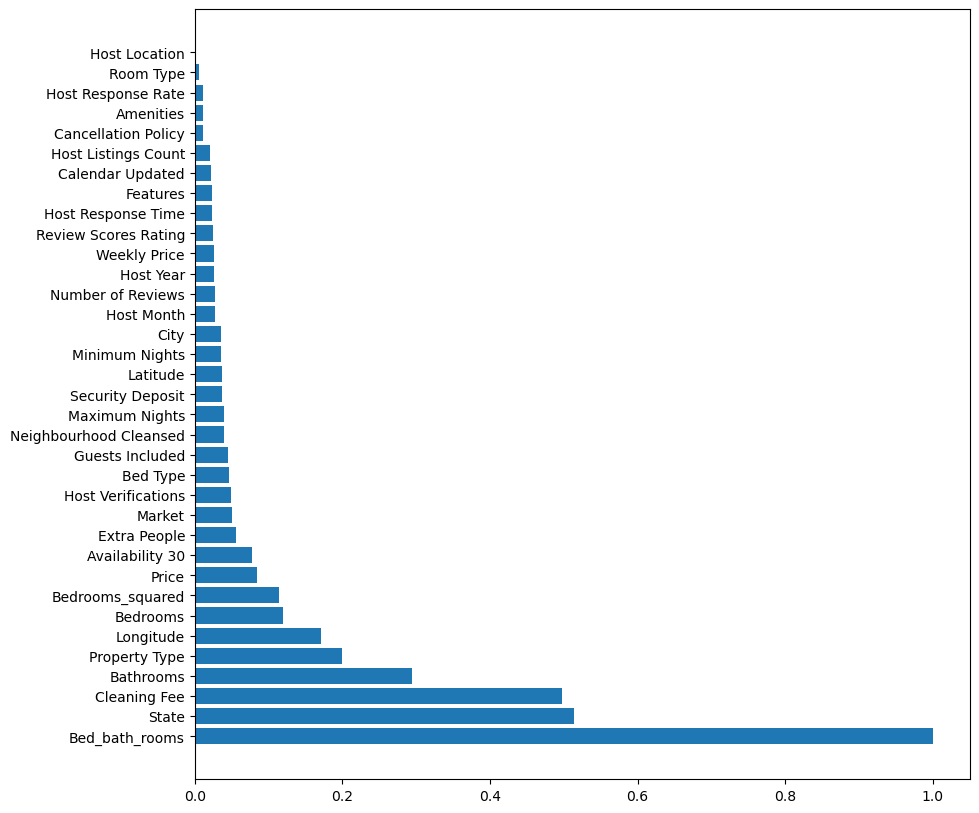

In [51]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

# **Conclusiones**

Como podemos ver ningún modelo consigue arrojarnos un score para los datos de test muy aceptable (descartando de primeras el árbol de decision). Con respecto a los modeos de random forest y Boosting Tree podemos ver como el primero consigue un mejor score en test y algo menos en train, por lo que Boosting Tree podría estar cayendo en algo más de overfitting (aunque claremente ocurre en ambos).

Por ello quizás, en este caso la "mejor opción" sería Lasso, ya que aunque su score es bajo, es muy similar en train y test y no desvía mucho el valor de test de los otros modelos, por lo que quizás la mejor opción sería usar Lasso tratando de ver si simplificando más el modelo (eliminando otras variables) o incluyendo alguna de las que descartarmos durante el ejercicio mejora el score.